## Introduction
This is a personal notebook for experimenting with different DL models as classifier for MNIST dataset.

In [165]:
import os
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf_v1
from tensorflow.keras.datasets import mnist
from tensorflow.compat.v1.keras import utils, callbacks, backend, layers, optimizers, Model, Input

## Local functions

In [359]:
def load_mnist_data():
    (train_x, train_y), (test_x, test_y) = mnist.load_data()
    # Make sure images have shape (28, 28, 1)
    train_x = np.expand_dims(train_x, axis=-1)
    test_x = np.expand_dims(test_x, axis=-1)
    # Scale images to the [0, 1] range
    train_x = train_x.astype("float32")/255.0
    test_x = test_x.astype("float32")/255.0
    # Reshape labels
    train_y = train_y.reshape(-1, 1)
    test_y = test_y.reshape(-1, 1)
    print(f"# Train data shape: {train_x.shape}")
    print(f"# Train label shape: {train_y.shape}")
    return (train_x, train_y), (test_x, test_y)

In [546]:
def get_model(input_shape, output_size, layer_size=5, num_layers=4, opt="adam"):
    img_input = Input(shape=input_shape, name="img_input")
    x = layers.Conv2D(filters=32, kernel_size=5)(img_input)
    x = layers.MaxPool2D(pool_size=3)(x)
    x = layers.Conv2D(filters=32, kernel_size=3)(x)
    x = layers.Flatten()(x)
    outputs = []
    for i in range(num_layers):
        x = layers.Dense(layer_size, activation="relu", name=f"dense_{i}", kernel_regularizer="l1" if i%2 else "l2")(x)
        x = layers.Dropout(0.2)(x)
        outputs.append(x)
    x = layers.Concatenate()(outputs)
    x = layers.Dense(0.5*layer_size*num_layers, activation="relu", kernel_regularizer="l2")(x)
    prob_out = layers.Dense(output_size, activation="softmax", name="prob_output")(x)
    model = Model(inputs=[img_input], outputs=[prob_out], name="classifier")
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])
    return model

In [547]:
def scheduler(epoch, const_till=10, lr=1e-3, min_lr=None, decay_rate=0.1):
    """
    Learning rate scheduler function
    """
    if min_lr is None:
        min_lr = 0.2*lr
    if epoch < const_till:
        return lr
    else:
        return max(min_lr, lr*np.math.exp(decay_rate*(const_till - epoch)))

## Load MNIST data

In [548]:
(train_x, train_y), (test_x, test_y) = load_mnist_data()

# Train data shape: (60000, 28, 28, 1)
# Train label shape: (60000, 1)


## Initialize model

In [571]:
backend.clear_session()
lr = 5e-3
opt = optimizers.Adam(lr=lr)
input_shape = train_x[0].shape
output_size = len(set(test_y.squeeze()))
classifier = get_model(input_shape=input_shape, output_size=output_size, layer_size=80, num_layers=4, opt=opt)
classifier.summary()

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   832         img_input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 32)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 32)     9248        max_pooling2d[0][0]              
_________________________________________________________________________________________

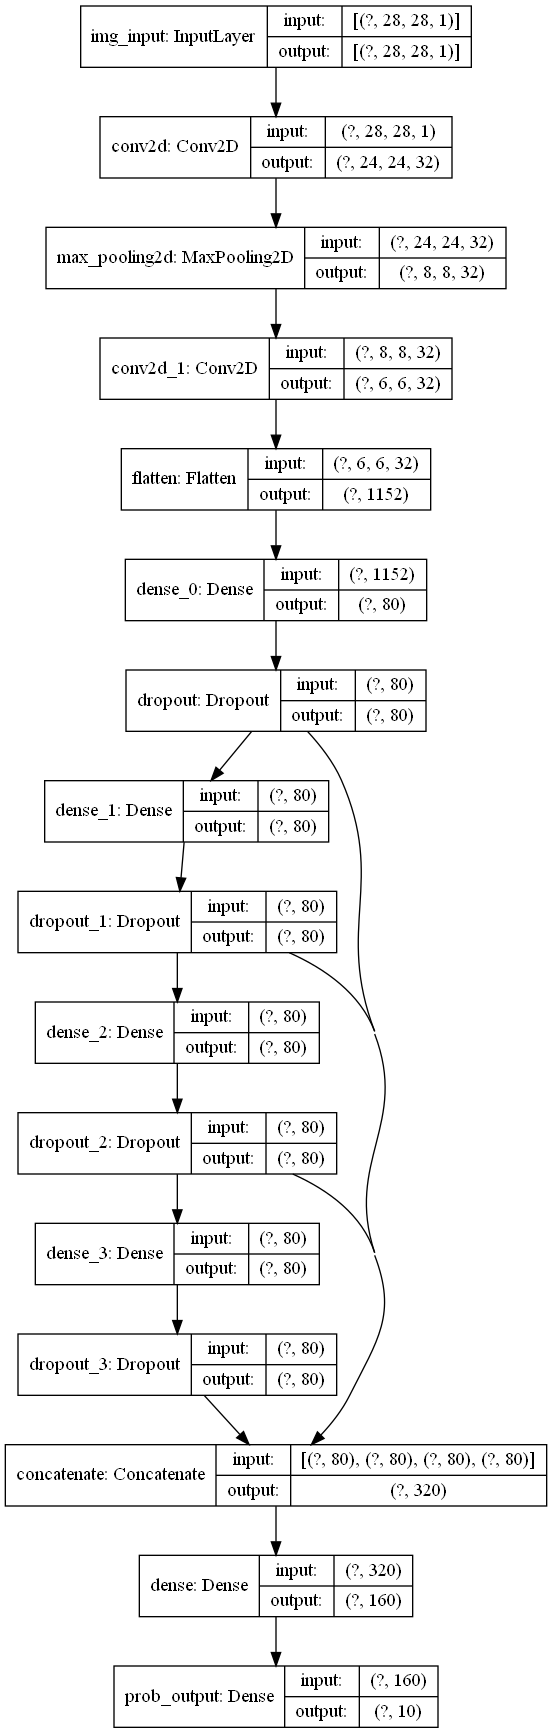

In [572]:
utils.plot_model(classifier, show_shapes=True)

## Train model

In [573]:
%%time
train_epoch = 100
batch_size = 256
lr_func = partial(scheduler, lr=lr, min_lr=5e-5, const_till=10, decay_rate=0.07)
lr_callback = callbacks.LearningRateScheduler(lr_func)
es_callback = callbacks.EarlyStopping(monitor="val_acc", mode="max", min_delta=0.0001, patience=17, restore_best_weights=False)
history = classifier.fit(train_x, train_y, epochs=train_epoch, batch_size=batch_size, validation_split=0.1, callbacks=[lr_callback, es_callback])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 29us/sample - loss: 1.7245 - acc: 0.8989 - val_loss: 0.3638 - val_acc: 0.9695
Epoch 2/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.4149 - acc: 0.9497 - val_loss: 0.3207 - val_acc: 0.9752
Epoch 3/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3881 - acc: 0.9542 - val_loss: 0.3355 - val_acc: 0.9720
Epoch 4/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3535 - acc: 0.9591 - val_loss: 0.2771 - val_acc: 0.9757
Epoch 5/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3396 - acc: 0.9609 - val_loss: 0.2662 - val_acc: 0.9827
Epoch 6/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3318 - acc: 0.9628 - val_loss: 0.2916 - val_acc: 0.9772
Epoch 7/100
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3279 - acc: 0.9653 - val_lo

## Plot training results

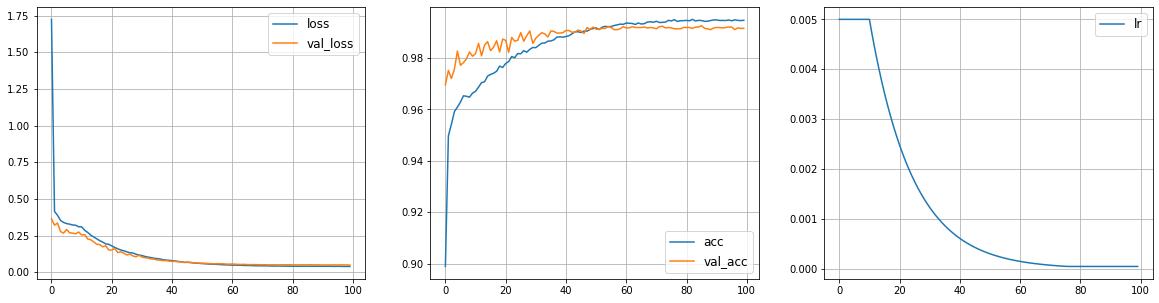

In [576]:
metrices = {key.split("_")[-1] for key in history.history.keys()}    
fig, axs = plt.subplots(1, len(metrices), figsize=(20, 5))
for metric_suffix, ax in zip(metrices, axs):
    legends = []
    for key, values in history.history.items():
        if key.endswith(metric_suffix):
            ax.plot(values)
            legends.append(key)
        ax.grid(True)
    ax.legend(legends, fontsize=12)

In [577]:
loss, acc = classifier.evaluate(test_x, test_y, batch_size=batch_size)
print(f"Loss: {loss:.4f} \nAccuracy: {acc:.4f}")

10000/10000 [==============================] - 0s 15us/sample - loss: 0.0443 - acc: 0.9926
Loss: 0.0443 
Accuracy: 0.9926


## Create Conv2D visualization model

In [540]:
outputs = {layer.name: layer.output for layer in classifier.layers if isinstance(layer, layers.Conv2D)}
viz_model = Model(inputs=[classifier.layers[0].input], outputs=outputs)

## Visualize on random test samples

In [541]:
num_samples = 10
test_indexes = np.random.choice(np.arange(test_y.shape[0]), size=num_samples)
viz_outputs = viz_model.predict(test_x[test_indexes])
labels = test_y[test_indexes].squeeze()

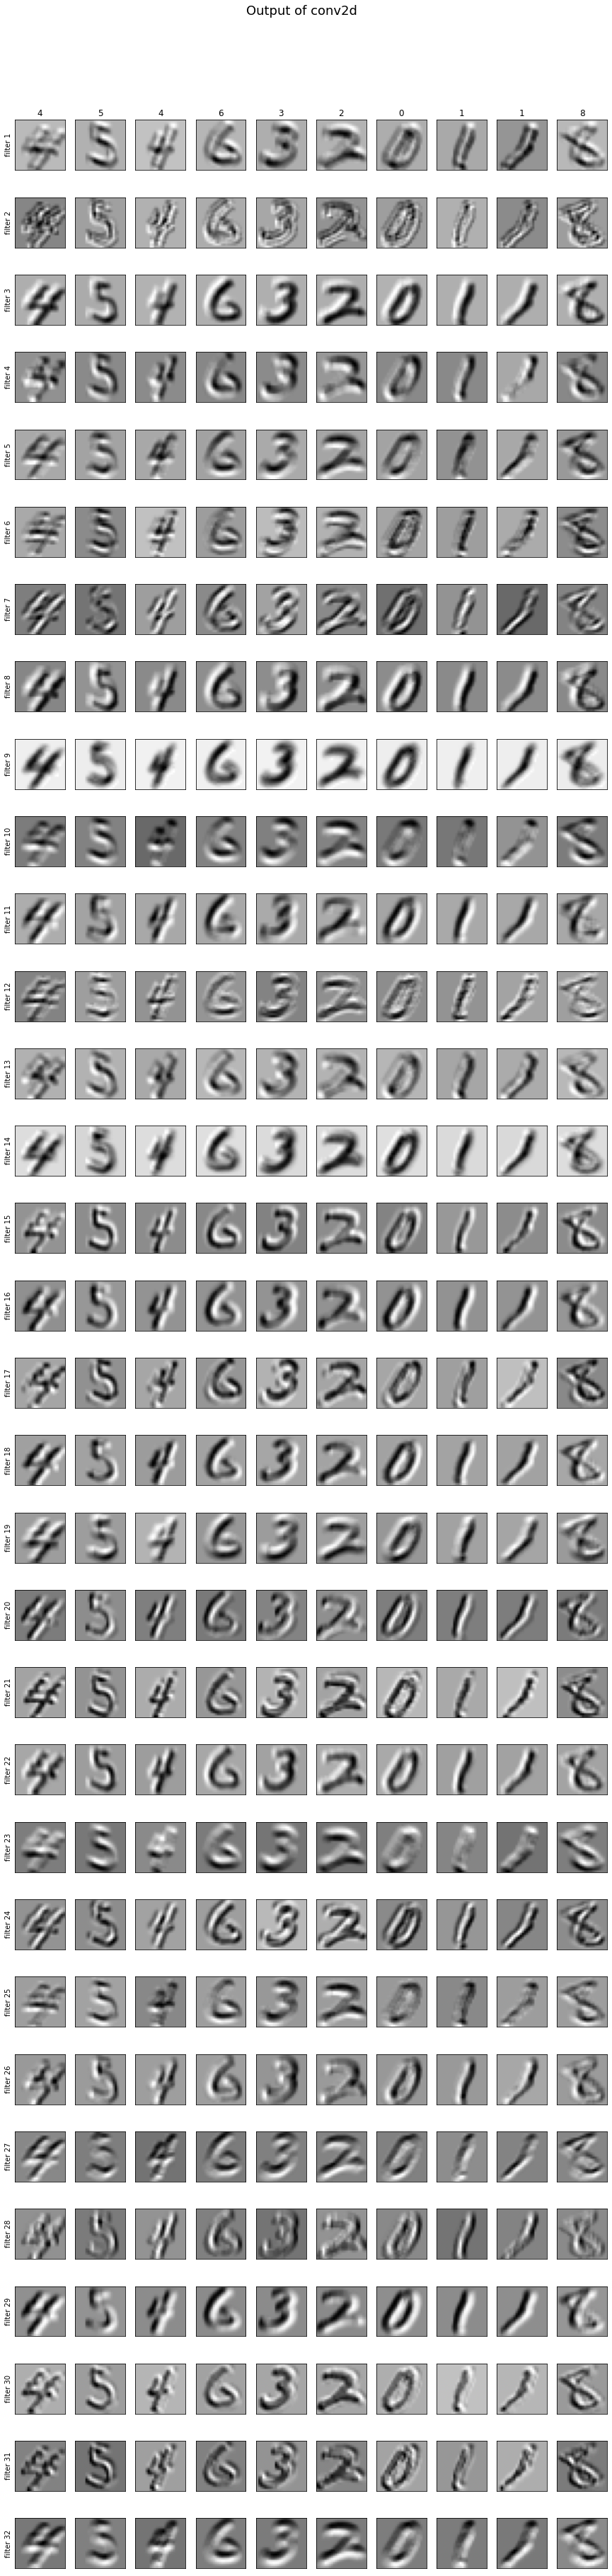

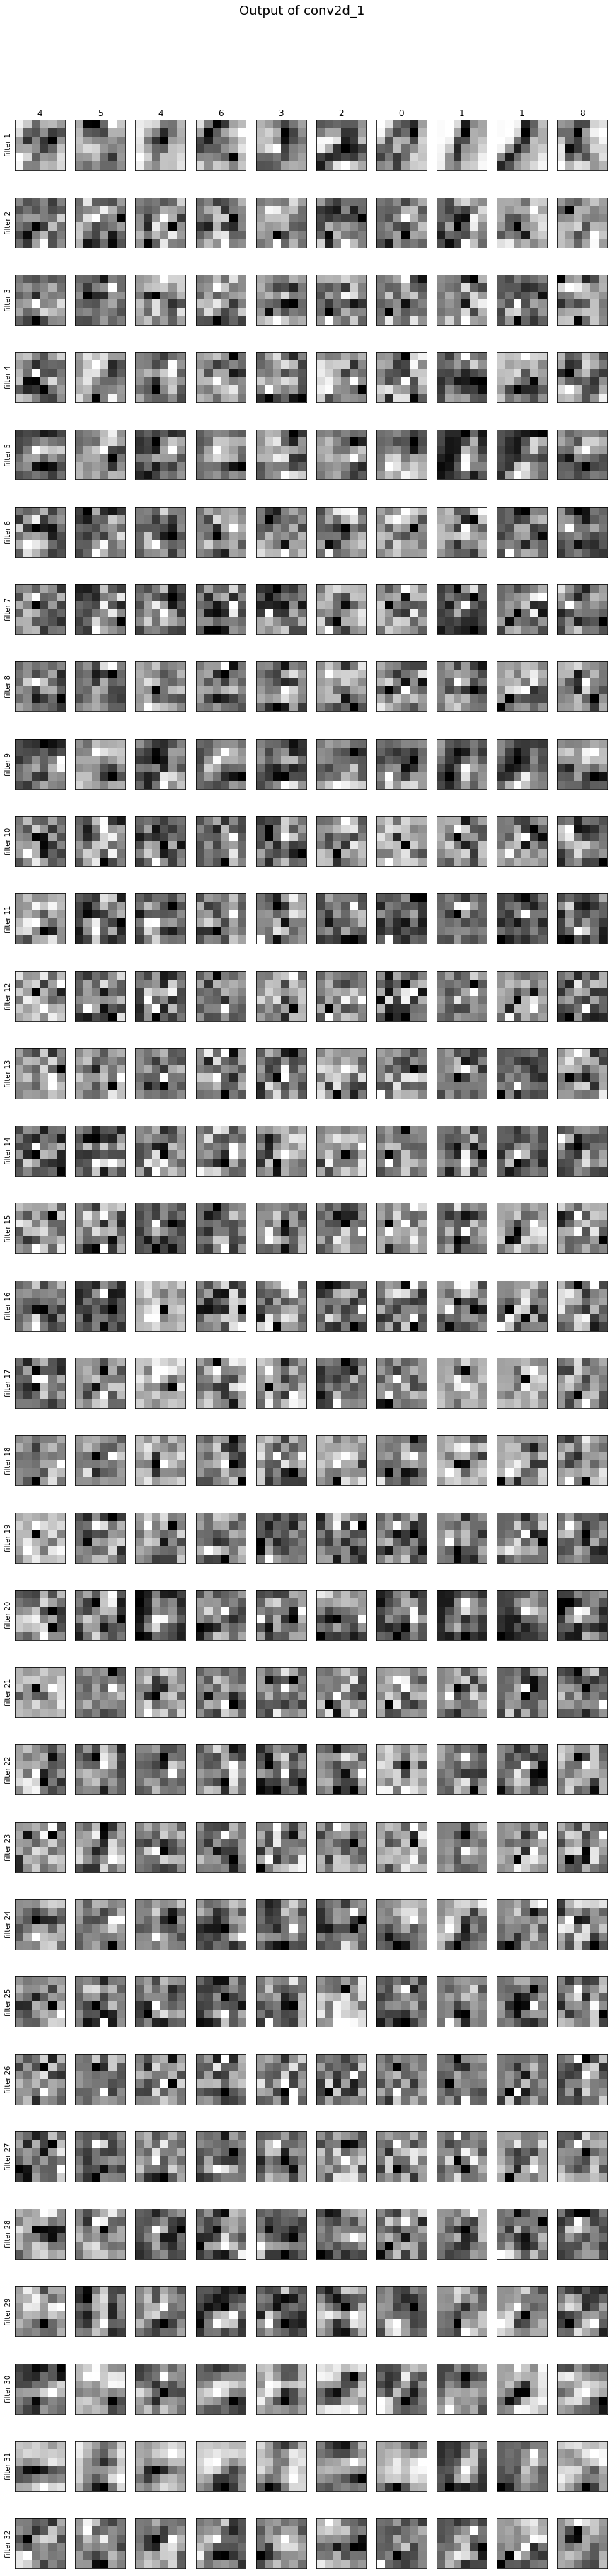

In [542]:
layer_names = tuple(outputs.keys())
for f in range(len(viz_outputs)):
    rows = len(viz_outputs[f][0][0][0])
    cols = len(viz_outputs[f])
    fig, axs = plt.subplots(rows, cols, figsize=(15, 2*rows))
    fig.text(0.5, 0.91, f"Output of {layer_names[f]}", ha='center', fontsize=18)
    for c in range(cols):
        for r in range(rows):
            axs[r, c].set_xticks([])
            axs[r, c].set_yticks([])
            if not c:
                axs[r, c].set_ylabel(f"filter {r+1}")
            if not r:
                axs[r, c].set_title(labels[c])
            img = axs[r, c].imshow(viz_outputs[f][c, :, :, r], cmap='gray')
    # fig.colorbar(img, ax=axs)
plt.show()

## Saving model
The command in the cell below reads the best evaluation accuracy so far from a text file and saves the current model and the accuracy value if the current model has the best accuracy so far. 

In [543]:
log_file = "best_eval_acc.txt"
if os.path.exists(log_file):
    print(f"Loading best accuracy value from '{log_file}'")
    with open(log_file, "r") as read_f:
        data_str = read_f.readline()
    best_acc = float(data_str.split(":")[-1])
else:
    best_acc = 0.0
print(f"Best accuracy: {best_acc:.5f} \nCurrent accuracy: {acc:.5f}")
if acc > best_acc:
    model_name = "best_mnist_classifier.h5"
    classifier.save(model_name)
    with open(log_file, "w") as write_f:
        write_f.write(f"best_acc:{acc}")
    print(f"Saved current model as '{model_name}' and accuracy log into '{log_file}'!")
else:
    print("Current model not saved!")

Loading best accuracy value from 'best_eval_acc.txt'
Best accuracy: 0.99340 
Current accuracy: 0.99080
Current model not saved!
